# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy\
matplotlib\
nest_asyncio\
jsonpath-ng\
ruamel.yaml\
cwl_utils
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import igraph              
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work
import glob
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))

import asyncio
import nest_asyncio
nest_asyncio.apply()

from wfqc.network import create_citation_network 
from wfqc.workflow import *
from wfqc.metrics import *

Check that the packages are installed and functional 

In [9]:
print("igraph version:", igraph.__version__) #TODO: sometimes this runs forever when it does not find cytoscape, sometimes not. check why
try: 
    dir(p4c)
    p4c.cytoscape_ping()    
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")

igraph version: 0.11.5
Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!


In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


In this pipeline I will be using the topic proteomics, but the method is not domain specific and works for any properly annotated CWL workflow. 

In [10]:
topicID = "topic_0121" # proteomics, which is also the default

## Downloading data 

Looking at the documentatio of the imported functions to see everythign is working as intended can be done by running `help(wfqc.data)` 

## Graph generation

### Load data

In [11]:
# path_to_data = 'data/out_cocitation'
path_to_data = 'out_202407041439' #'old_outs/out_202406061622'

G = create_citation_network(inpath=path_to_data) # TODO: if no data then make data or ask if make data?


### Generate new graph


#### Test size

For example with a smaller testsize 

In [ ]:
G = asyncio.run(create_citation_network(loadData=False, testSize=20))
print(G.vs['name'])

#### Full network

Or the entire bio.tools database proteomics topic (default), or another specified topic:

In [3]:
G = create_citation_network(loadData=False, topicID = topicID) 

NameError: name 'topicID' is not defined

Lets check what attributes the co-citation graph has, and that the it was correctly generated

In [6]:
graph_attributes = G.vs.attributes()
print("Graph-level attributes:", graph_attributes)

edge_attributes = G.es.attributes()
print("Edge-level attributes:", edge_attributes)
print(f"Max edge weight is {max(list(G.es['weight']))}, min edge weight is {min(G.es['weight'])}")

Graph-level attributes: ['name']
Edge-level attributes: ['weight']
Max edge weight is 1986, min edge weight is 1


In [8]:
degrees = [vs.degree() for vs in G.vs]
weigths_edges = G.es['weight']

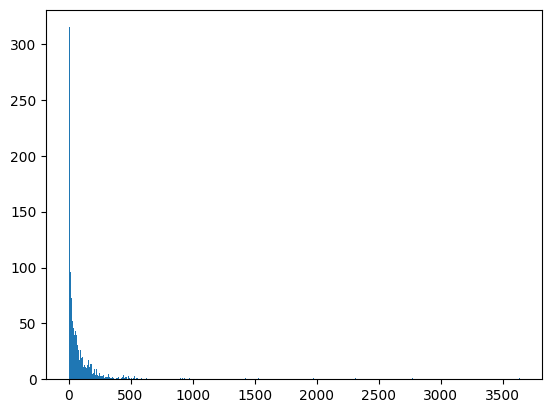

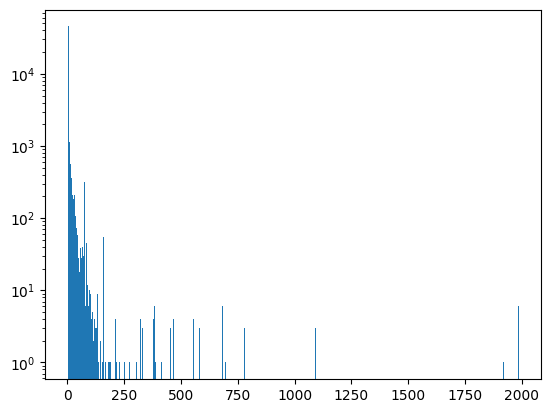

In [9]:
plt.hist(degrees, bins=500
         )
plt.show()
plt.hist(weigths_edges, bins=500
         )
plt.yscale('log')
plt.show()

In [10]:
print("median weight:",  np.median(list(G.es['weight'])))
print("mean weight:",np.mean(list(G.es['weight'])))

median weight: 1.0
mean weight: 4.582077307589575


## The metric

### Download workflow data


Load the latest bio.tools file 

In [67]:
date_format = "%Y%m%d"
pattern = f'biotools_metadata_{topicID}*'
matching_files = glob.glob(pattern)

if matching_files:
    matching_files.sort(key=os.path.getmtime)
    csvfile = matching_files[-1] # get the latest file
    print(f"Bio.tools data loaded from existing CSV file {csvfile}.")


In [69]:
#"no longer using that so lets temp define it"
csvfile ='tests/data/biotools_metadata_topic_0121_20250516.csv'

Test that loading one workflow works

In [76]:
cwl_file = "./workflows/APE/candidate_workflow_2.cwl" # loading one of the APE generated workflows 
included_tools = G.vs['name'] # no longer used but ok

workflow_pairs, workflow_tools = parse_undocumented_workflows(cwl_file, csvfile) # TODO: more than one at a time? 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, len(workflow_pairs)) # TODO: could improve the rand wf method to have the same shape as the og nw by 
                                                                                                    # adding 

print(workflow_pairs, rand_workflow_pairs)

[('24727770', '10612281'), ('23536269', '10612281'), ('24727770', '20673335'), ('20673335', '24727770')] [(np.str_('16335983'), np.str_('32714868')), (np.str_('20049890'), np.str_('31878100')), (np.str_('31075275'), np.str_('36912639')), (np.str_('32133024'), np.str_('36094961'))]


could add visualisation of the workflows and the original workflows. 

### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

Test that calculating the metric for one workflow works

In [77]:
# For one workflow
metric_score, raw_results = sum_metric(G, workflow_pairs, included_tools)

print(raw_results)
print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[2, 2, 2, 2]
Total cocitation score for workflow [('24727770', '10612281'), ('23536269', '10612281'), ('24727770', '20673335'), ('20673335', '24727770')] is 2.0.


### Evaluate results 

OBS: This section continues with the co-citation graph in mind

These are the tools included in workflomics, but we will not use them right now

In [14]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have pmid info

If the workflows contain only annotated tools:

In [ ]:
workflows = []
rand_workflows = []

#TODO: make this a function?
#TODO. verify all the functions involved in this using some mock nw or sth

#def load_workflows(workflow_directory)

pattern = f'workflows/APE/candidate_workflow_*'
matching_files = glob.glob(pattern)
#nr_files = len(matching_files)

# Right now as the name generation is wrong: 

sorted_match = np.sort([int(path.split("_")[-1].strip(".cwl")) for path in matching_files])
nr_files = sorted_match[-1]


for i in range(1, nr_files+1):

    if '8' in str(i) or '9' in str(i):
        i += 1
        continue


    cwl_file = f"workflows/APE/candidate_workflow_{i}.cwl"
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file, csvfile) # TODO: more than one at a time  #TODO: thsi is no longer a list f pmids, thus it is not functional
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        print("no", cwl_file)
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

If the workflows contain non annotated tools:


In [ ]:
workflows = []
rand_workflows = []

#TODO: make this a function?
#TODO. verify all the functions involved in this using some mock nw or sth

pattern = f'workflows/APE/candidate_workflow_*'
matching_files = glob.glob(pattern)
#nr_files = len(matching_files)

# Right now as the name generation is wrong: 

sorted_match = np.sort([int(path.split("_")[-1].strip(".cwl")) for path in matching_files])
nr_files = sorted_match[-1]
actural_nr_files =  len(matching_files)

nr_not_func = 0

for i in range(1, nr_files+1):

    if '8' in str(i) or '9' in str(i):
        continue


    cwl_file = f"workflows/APE/candidate_workflow_{i}.cwl"
    try:
        workflow_pairs, workflow_tools = parse_undocumented_workflows(cwl_file, csvfile) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        nr_not_func += 1
        continue 


print(workflows, rand_workflows) 

The workflows may contain tools that are not in our bio.tools file (they dont have pmids), so let's check how many we got:

In [83]:
print(len(workflows), " out of ", actural_nr_files)

953  out of  1000


If you want to save them:

In [186]:
import pickle
savewf = True
if savewf:
    with open('./wfedges.pkl', 'wb') as f:
        pickle.dump(workflows, f)
    with open('./rndwfedges.pkl', 'wb') as f:
        pickle.dump(rand_workflows, f)


Run the metric on all tools

In [84]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = sum_metric(G, workflows[i], included_tools)
    rand_metric_score, rand_raw_results = sum_metric(G, rand_workflows[i], included_tools)

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    

/home/alma/Documents/UU/Thesis/Git/workflomics-QCmetric/src/wfqc/metrics.py:97: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  results = G.get_shortest_paths(source, to=target, weights=G.es["weight"], output="epath")


This is the shortest path measurement, so the lower the metric score the "better"

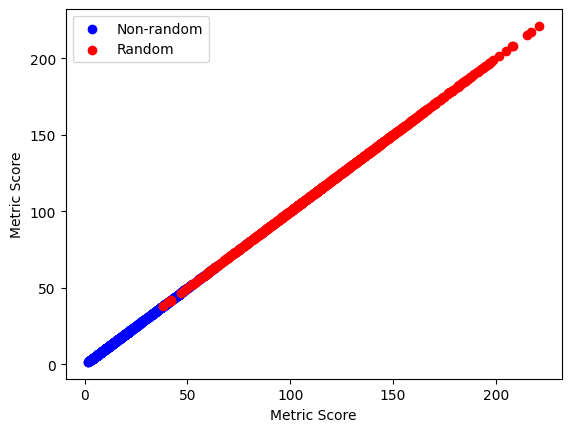

In [198]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.legend()
plt.show()


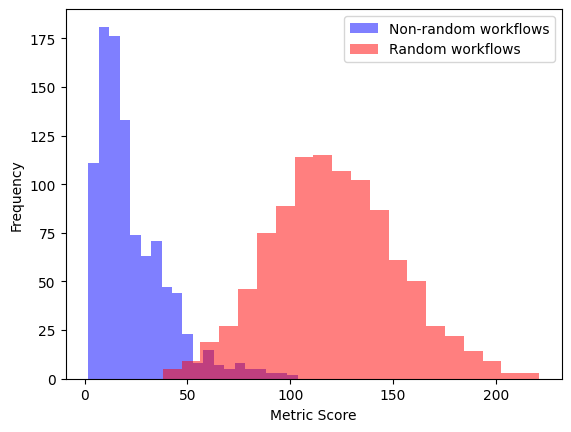

In [199]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random workflows')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random workflows')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()


# Show plot
plt.show()


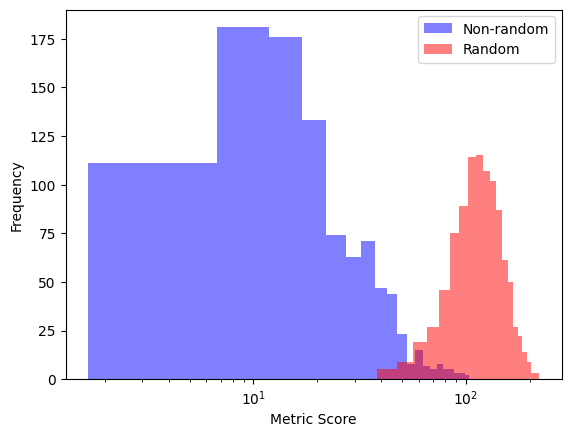

In [200]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # focus on blue dist

# Show plot
plt.show()


Obviously this comparison is not very fair and we should make sure that the "functional workflows" are drawn from the same set as the randoms, whereas now they are drawn from a very small subset of very well annotated tools. This is more to show that the comparison works, not that the results are reliable. 

## Visualisation


Using cytoscape to visualise the network

In [63]:

current_time = datetime.now().strftime("%Y%m%d%H%M")

p4c.create_network_from_igraph(G, f"Cocitations_{current_time}", collection="Citation networks")

# edge_attributes = p4c.get_table_columns(table='edge', columns=['weight'])
# weights = edge_attributes['weight']

Applying default style...
Applying preferred layout


362

In [ ]:
print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)


In [ ]:
# Styling edges
p4c.set_edge_label_mapping('weight')
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('weight', mapping_type='c'))